## **Aplicação de Regressão Linear Simples e Múltipla**
Neste notebook são aplicados os modelos de regressão linear simples e múltipla, bem como a construção de features para captura de sazonalidade e outras características das séries temporais.
Para avaliação do desempenho do modelo, serão utilizadas as métricas **MAE**, **MSE**, **RMSE** e **R²**, comparados aos modelos benchmark **SARIMA** e **ETS**. 

In [1]:
# confirgurando diretório
import os
os.chdir("..")

# importando bibliotecas
import warnings
from tqdm import tqdm
import pandas as pd
import numpy as np
import holidays
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from statsforecast import StatsForecast 
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS
from statsmodels.tsa.seasonal import STL
from main.evaluation import Evaluation
from main.plots import plot_hist
from main.plots import plot_time_series

# configurando notebook
tqdm.pandas()

warnings.filterwarnings("ignore")

pd.set_option('display.float_format', lambda x: '%.2f' % x)

%load_ext autoreload
%autoreload 2

## **Leitura dos Dados**
Leitura dos dados de treino e teste exportados no notebook *analise_exploratoria.ipynb*. Para cada série, foram separados os 70% primeiros pontos de dados para treino e o restante, ou seja, os dados mais recentes, para teste.

In [2]:
# leitura dos dados
train_df = pd.read_csv("notebooks/data/train_df.csv", parse_dates=['ds'])
test_df = pd.read_csv("notebooks/data/test_df.csv", parse_dates=['ds'])

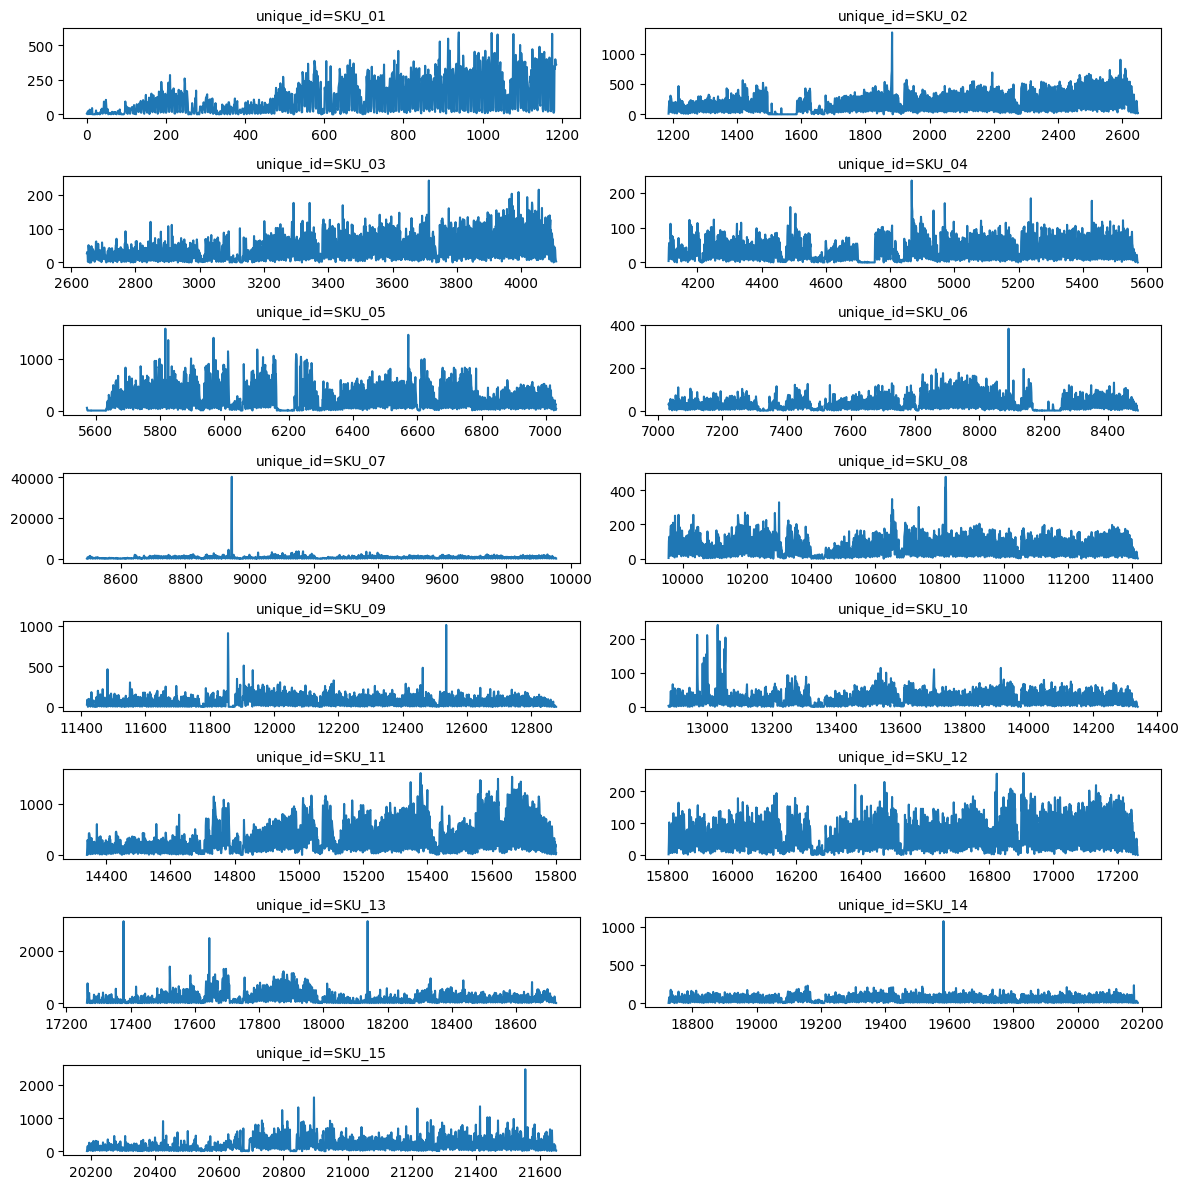

In [3]:
# visualizando dados de treino
plot_time_series(df=train_df, data_cols=['y'], figsize=(12,12))

## **Regressão Linear Simples**
Uma abordagem do modelo de regressão linear aplicado a séries temporais pode ser visto em [Forecasting: Principles and Practice (3rd ed) - The linear model](https://otexts.com/fpp3/regression-intro.html).\
 Aqui, a única feature é o índice temporal dado por $x_t = t$, onde $t = 0, 1, 2 ... N$, sendo $N$ o número de observações na série.

In [4]:
def linear_regression(df : pd.DataFrame) -> pd.DataFrame:
    """
    Aplicação do modelo simples de regressão linear. Usa a ordem t como regressor.
    """    
    train = df.copy().reset_index(drop=True)
    test = test_df.query("unique_id == @train.unique_id[0]").reset_index(drop=True)
    test.index = test.index + train.index.max() + 1

    m = LinearRegression()
    m.fit(X=train.index.values.reshape(-1,1), 
          y=train.y)
    test['y_pred'] = m.predict(X=test.index.values.reshape(-1,1))

    return test

In [5]:
# aplicando modelo para cada série
lr_fcst = train_df.groupby("unique_id").apply(linear_regression).reset_index(drop=True)

In [6]:
lr_eval = Evaluation(lr_fcst).summary()
lr_eval

,mae,mse,rmse,r2
SKU_01,155.88,35483.70,188.37,-0.16
SKU_02,195.14,53661.07,231.65,-0.03
SKU_03,45.89,3088.51,55.57,-0.08
SKU_04,31.00,1454.92,38.14,-0.02
SKU_05,462.16,301886.87,549.44,-0.58
SKU_06,26.08,1027.98,32.06,-0.41
SKU_07,503.46,348056.46,589.96,-0.53
SKU_08,49.37,3081.21,55.51,-0.38
SKU_09,42.67,3022.23,54.97,-0.03
SKU_10,13.93,356.42,18.88,-0.19


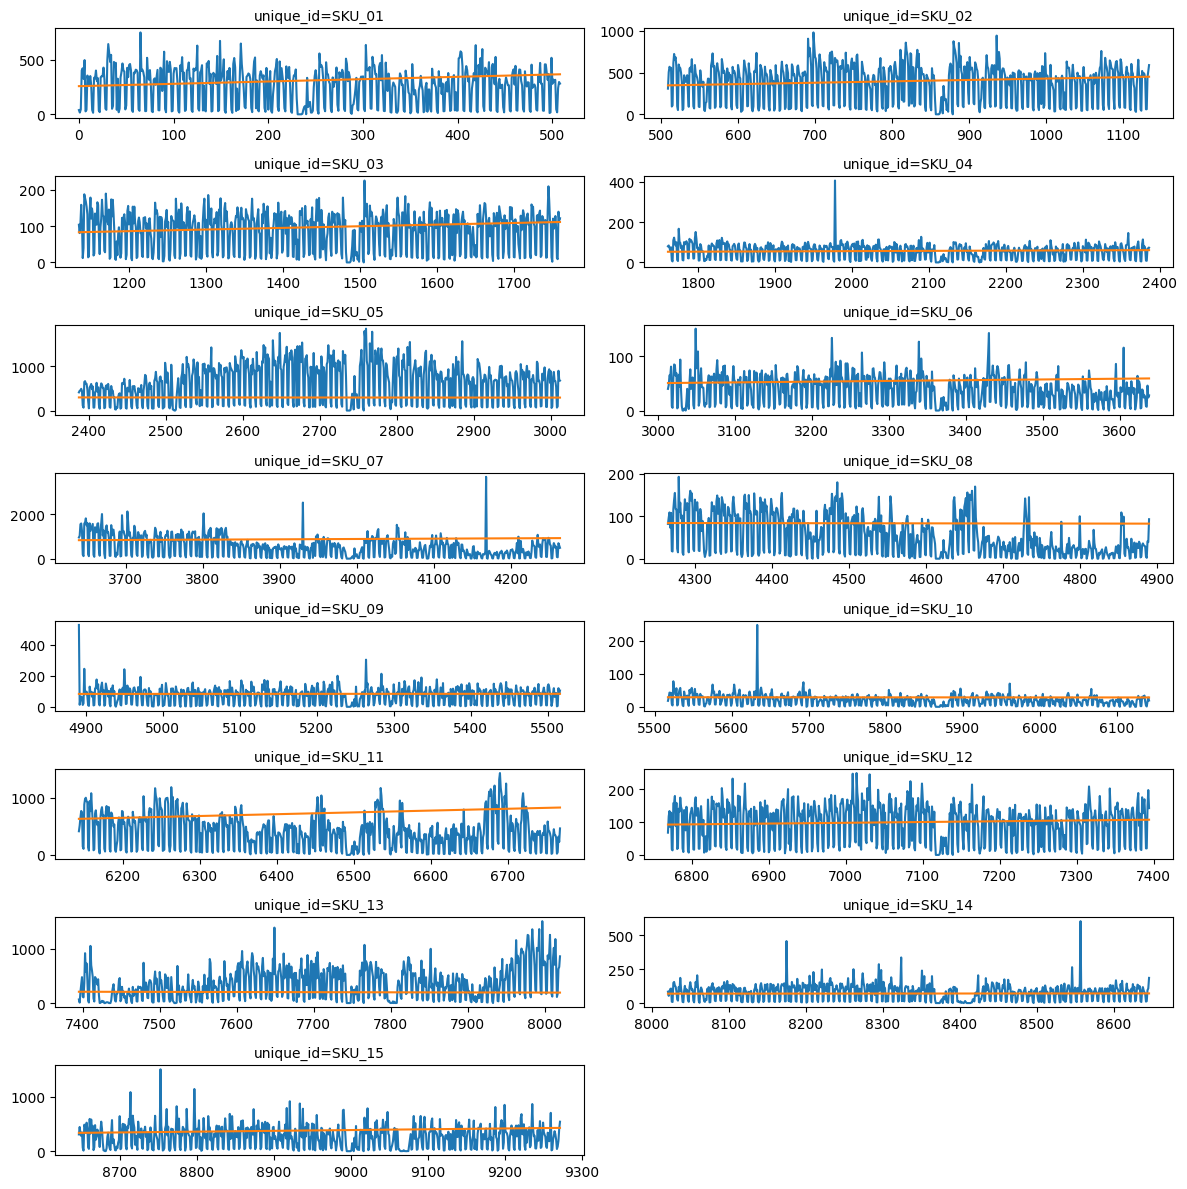

In [7]:
# plot das previsões 
plot_time_series(df=lr_fcst, data_cols=['y', 'y_pred'], figsize=(12,12))

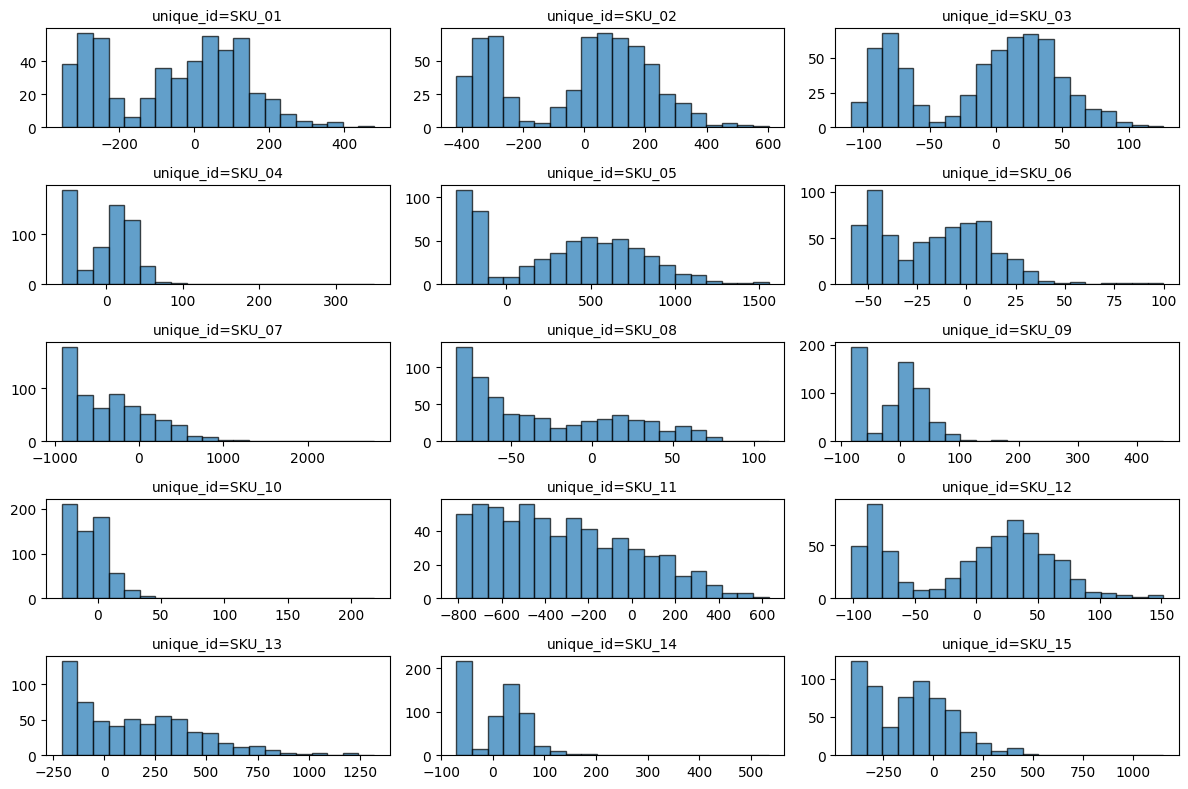

In [8]:
# plot dos resíduos do modelo
plot_hist(
    df=lr_fcst.assign(residual = lambda x: x['y'] - x['y_pred']),
    id_col='unique_id',
    data_col=['residual'],
    ids=lr_fcst.unique_id.unique(),
    grid=(5, 3),
    figsize=(12, 8)
)

## **Engenharia de Características**
Acrescentaremos algumas features para tentar captar a sazonalidade treinando um modelo de regressão linear múltipla.
Algums preditores são sugeridos em [Forecasting: Principles and Practice (3rd ed) - Useful Predictors](https://otexts.com/fpp3/useful-predictors.html).

In [9]:
# funções para criação de features
def feriados(dia: str) -> pd.DataFrame:
    """Valida se uma data é feriado nacional.

    Args:
        dia (str): Dia para validação.

    Returns:
        pd.DataFrame: 1 (sim) ou 0 (não) para cada localidade.
    """
    dia = pd.to_datetime(dia)
    feriados_br = holidays.country_holidays('BR')

    return 1 if dia in feriados_br else 0


def outliers(df : pd.DataFrame, target_col : str = 'y') -> np.ndarray:
    """Calcula outliers com base em 3*IQR dos dados 
    e atribui ao df duas colunas, uma para outliers de mínimo e outra para máximo.

    Args:
        df (pd.DataFrame): Dados originais para calcular e inserir colunas.
        target_col (str, optional): Coluna com dados usados para cálculo. Padrão é 'y'.

    Returns:
        pd.DataFrame: DataFrame expendido com colunas indicando outliers.
    """
    stl = STL(df[target_col], period=365)
    res = stl.fit()
    q1 = res.resid.quantile(0.25)
    q3 = res.resid.quantile(0.75)
    iqr = q3 - q1
    limite_inf = q1 - 3 * iqr
    limite_sup = q3 + 3 * iqr

    df['outlier_min'] = np.where(df[target_col] < limite_inf, 1, 0)
    df['outlier_max'] = np.where(df[target_col] > limite_sup, 1, 0)

    return df


def add_features(
        df : pd.DataFrame,
        df_type : str,
        time_col : str = 'ds',
) -> pd.DataFrame:
    """Adiciona features de calendário e outliers ao dataframe.

    Args:
        df (pd.DataFrame): DataFrame contendo coluna de data no tipo datetime 
            e coluna de valores para calculo de outliers.
        df_type (str): Se o DataFrame é de treino ou teste.
            Implica em atribuir outliers se for treino, ou não atribuir se for teste.
        time_col (str, optional): Nome da coluna de datas. Padrão é 'ds'.
        target_col (str, optional): Nome da coluna target. Padrão é 'y'.

    Returns:
        pd.DataFrame: DataFrame expandido com as features.
    """
    df['feriado'] = df[time_col].apply(feriados)
    df['day_of_week'] = df[time_col].dt.day_of_week
    df['week'] = df[time_col].dt.isocalendar().week.astype(str)
    df['month'] = df[time_col].dt.month
    df['quarter'] = df[time_col].dt.quarter
    
    if df_type == 'train':
        df = outliers(df)
    else: 
        df[['outlier_min', 'outlier_max']] = 0

    return df

In [10]:
# inserindo as features nos dados de treino e teste
features_train_df = (
    train_df
    .groupby("unique_id")
    .apply(lambda x: add_features(df=x, df_type='train'))
    .reset_index(drop=True)
)

features_test_df = (
    test_df
    .groupby("unique_id")
    .apply(lambda x: add_features(df=x, df_type='test'))
    .reset_index(drop=True)
)

In [11]:
features_train_df.head()

,unique_id,ds,y,feriado,day_of_week,week,month,quarter,outlier_min,outlier_max
0,SKU_01,2020-01-28,4.00,0,1,5,1,1,0,0
1,SKU_01,2020-01-29,1.00,0,2,5,1,1,0,0
2,SKU_01,2020-01-30,19.00,0,3,5,1,1,0,0
3,SKU_01,2020-01-31,23.00,0,4,5,1,1,0,0
4,SKU_01,2020-02-01,4.00,0,5,5,2,1,0,0


In [12]:
features_test_df.head()

,unique_id,ds,y,feriado,day_of_week,week,month,quarter,outlier_min,outlier_max
0,SKU_01,2023-04-29,39.00,0,5,17,4,2,0,0
1,SKU_01,2023-04-30,16.00,0,6,17,4,2,0,0
2,SKU_01,2023-05-01,45.00,1,0,18,5,2,0,0
3,SKU_01,2023-05-02,403.00,0,1,18,5,2,0,0
4,SKU_01,2023-05-03,423.00,0,2,18,5,2,0,0


In [13]:
categories = ['day_of_week','week', 'month', 'quarter']

encoder = OneHotEncoder(drop='first')
encoder.fit(features_train_df[categories])


# aplicando nos dados de treino
X_train_encoded = pd.DataFrame(
    data = encoder.transform(features_train_df[categories]).toarray(), 
    columns=encoder.get_feature_names_out()
)

encoded_train_df = pd.concat(
    [features_train_df.drop(columns=categories), X_train_encoded], 
    axis=1
)


# aplicando nos dados de teste
X_test_encoded = pd.DataFrame(
    data = encoder.transform(features_test_df[categories]).toarray(), 
    columns=encoder.get_feature_names_out()
)

encoded_test_df = pd.concat(
    [features_test_df.drop(columns=categories), X_test_encoded], 
    axis=1
)

In [14]:
encoded_train_df.head()

,unique_id,ds,y,feriado,outlier_min,outlier_max,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,...,month_6,month_7,month_8,month_9,month_10,month_11,month_12,quarter_2,quarter_3,quarter_4
0,SKU_01,2020-01-28,4.00,0,0,0,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,SKU_01,2020-01-29,1.00,0,0,0,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,SKU_01,2020-01-30,19.00,0,0,0,0.00,0.00,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,SKU_01,2020-01-31,23.00,0,0,0,0.00,0.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,SKU_01,2020-02-01,4.00,0,0,0,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [15]:
encoded_test_df.head()

,unique_id,ds,y,feriado,outlier_min,outlier_max,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,...,month_6,month_7,month_8,month_9,month_10,month_11,month_12,quarter_2,quarter_3,quarter_4
0,SKU_01,2023-04-29,39.00,0,0,0,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
1,SKU_01,2023-04-30,16.00,0,0,0,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
2,SKU_01,2023-05-01,45.00,1,0,0,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
3,SKU_01,2023-05-02,403.00,0,0,0,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
4,SKU_01,2023-05-03,423.00,0,0,0,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00


## **Regressão Linear Múltipla**

In [16]:
def multiple_linear_regression(df : pd.DataFrame) -> pd.DataFrame:
    """
    Aplicação do modelo de regressão linear múltipla.
    """    
    train = df.copy().reset_index(drop=True)
    test = encoded_test_df.query("unique_id == @train.unique_id[0]").reset_index(drop=True)

    train['trend'] = train.index
    test['trend'] = test.index + train.index.max() + 1
    
    m = LinearRegression()
    m.fit(
        X=train.iloc[:,3:], 
        y=train.y
    )
    
    test['y_pred'] = m.predict(X=test.iloc[:,3:])

    return test

In [17]:
mlr_fcst = (
    encoded_train_df
    .groupby("unique_id")
    .apply(multiple_linear_regression)
    .reset_index(drop=True)
)

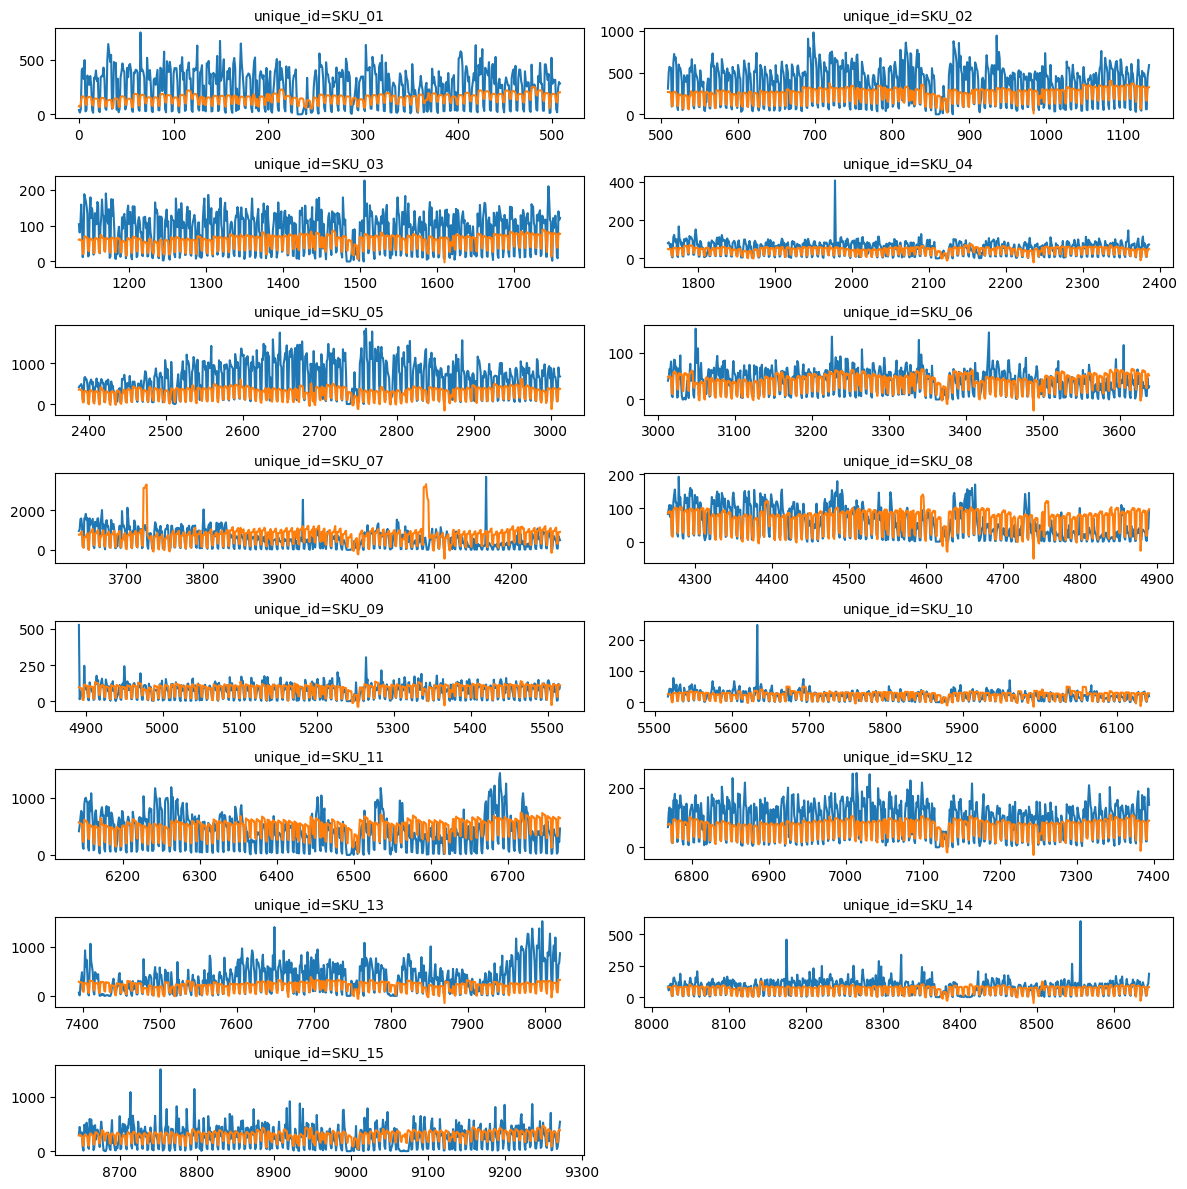

In [18]:
plot_time_series(
    df = mlr_fcst,
    data_cols=['y','y_pred'],
    grid=(8, 2),
    figsize=(12, 12)
)

In [19]:
mlr_eval = Evaluation(mlr_fcst).summary()
mlr_eval

,mae,mse,rmse,r2
SKU_01,151.19,33438.69,182.86,-0.09
SKU_02,175.86,46032.41,214.55,0.11
SKU_03,40.37,2403.50,49.03,0.16
SKU_04,21.28,896.21,29.94,0.37
SKU_05,364.99,230854.83,480.47,-0.21
SKU_06,14.87,393.74,19.84,0.46
SKU_07,378.99,298291.96,546.16,-0.31
SKU_08,30.67,1494.08,38.65,0.33
SKU_09,23.71,1234.21,35.13,0.58
SKU_10,8.48,192.02,13.86,0.36


## **Comparação com Modelos Benchmark**

In [20]:
models = [
    AutoARIMA(season_length=7),
    AutoETS(season_length=7)
]

sf = StatsForecast(
    models=models,
    freq='D',
    n_jobs=-1
)

def arima_ets_models(df):
    """
    Aplica os modelos SARIMA e ETS.
    """
    train = df.copy().reset_index(drop=True)
    test = test_df.query("unique_id == @train.unique_id[0]").reset_index(drop=True)

    sf.fit(df=train)
    predict = sf.predict(h=len(test)).reset_index(drop=True)
    
    test['ARIMA'] = predict['AutoARIMA']
    test['ETS'] = predict['AutoETS']
    return test

In [21]:
benchmark_fcst = train_df.groupby("unique_id").progress_apply(arima_ets_models).reset_index(drop=True)

100%|██████████| 15/15 [04:17<00:00, 17.15s/it]


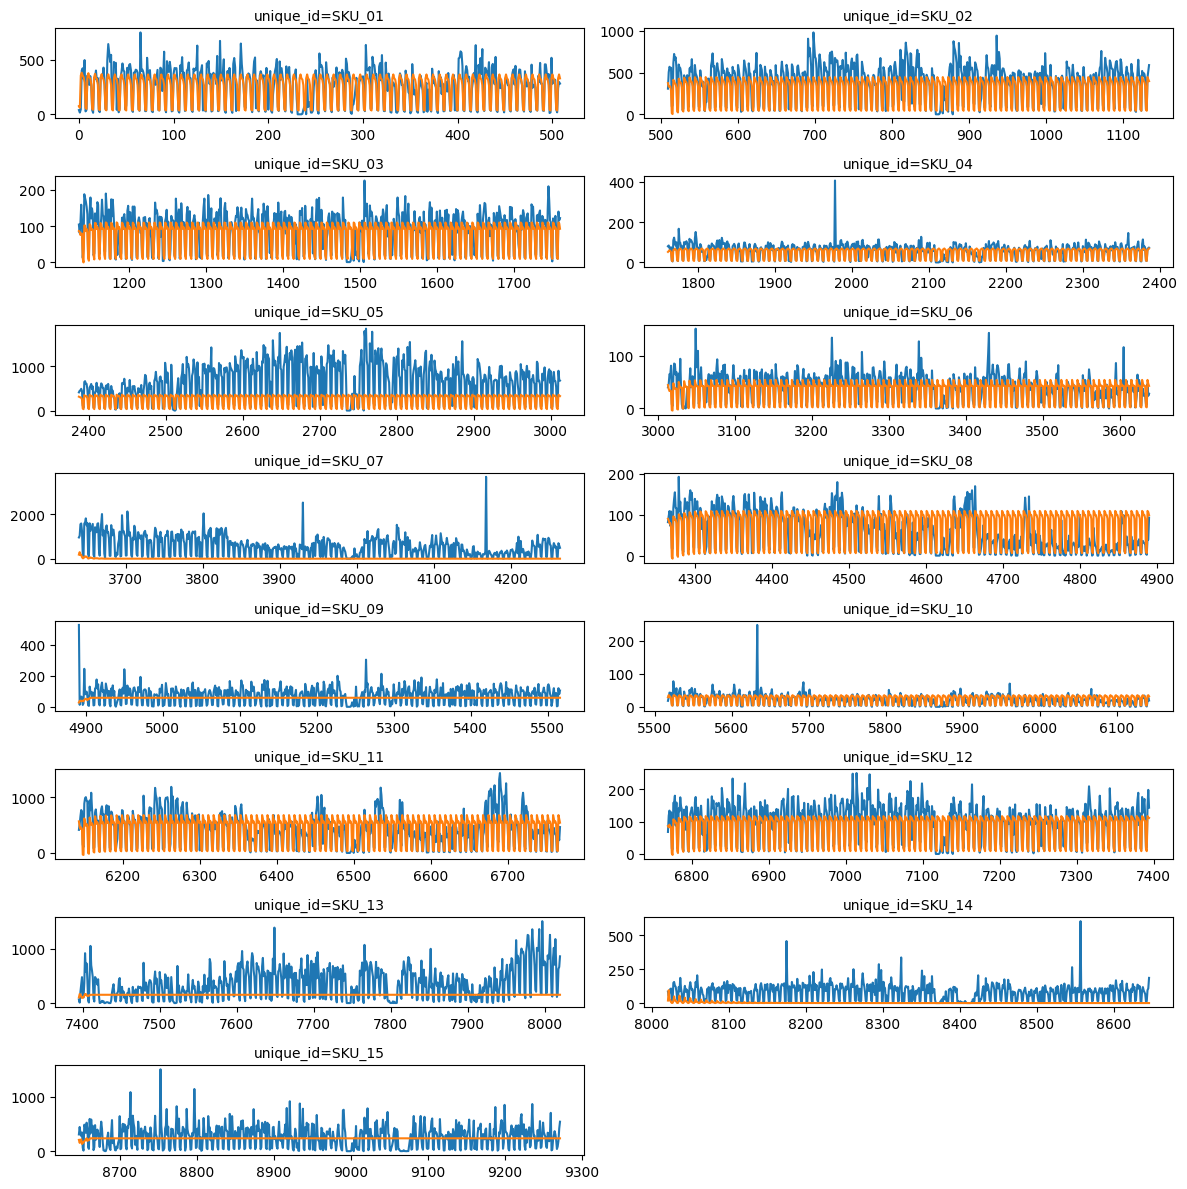

In [22]:
# plot das previsões ARIMA
plot_time_series(
    df=benchmark_fcst,
    data_cols=['y','ARIMA'],
    id_col='unique_id',
    grid=(8, 2),
    figsize=(12, 12)
)

In [23]:
arima_eval = Evaluation(df=benchmark_fcst, y_pred_col='ARIMA').summary()
arima_eval

,mae,mse,rmse,r2
SKU_01,69.77,11134.58,105.52,0.64
SKU_02,112.02,23121.26,152.06,0.55
SKU_03,24.12,1112.21,33.35,0.61
SKU_04,15.95,678.73,26.05,0.53
SKU_05,401.57,264902.96,514.69,-0.39
SKU_06,13.67,382.68,19.56,0.48
SKU_07,549.53,525905.19,725.19,-1.31
SKU_08,33.63,2031.71,45.07,0.09
SKU_09,47.43,3234.17,56.87,-0.10
SKU_10,8.25,200.85,14.17,0.33


In [24]:
ets_eval = Evaluation(df=benchmark_fcst, y_pred_col='ETS').summary()
ets_eval

,mae,mse,rmse,r2
SKU_01,75.38,11178.93,105.73,0.63
SKU_02,211.24,55430.45,235.44,-0.07
SKU_03,51.31,3197.07,56.54,-0.11
SKU_04,34.08,1607.15,40.09,-0.12
SKU_05,477.77,338422.03,581.74,-0.77
SKU_06,22.75,749.26,27.37,-0.03
SKU_07,297.59,149857.72,387.11,0.34
SKU_08,36.22,1680.67,41.00,0.25
SKU_09,52.11,3665.62,60.54,-0.25
SKU_10,11.02,251.26,15.85,0.16


In [25]:
# comparação dos modelos
metric = 'rmse'
eval_dfs = [lr_eval, mlr_eval, arima_eval, ets_eval]
result = pd.concat([df[metric] for df in eval_dfs], axis=1)
result.columns = [f'{x}_{metric}' for x in ['LR','MLR','ARIMA','ETS']]
result

,LR_rmse,MLR_rmse,ARIMA_rmse,ETS_rmse
SKU_01,188.37,182.86,105.52,105.73
SKU_02,231.65,214.55,152.06,235.44
SKU_03,55.57,49.03,33.35,56.54
SKU_04,38.14,29.94,26.05,40.09
SKU_05,549.44,480.47,514.69,581.74
SKU_06,32.06,19.84,19.56,27.37
SKU_07,589.96,546.16,725.19,387.11
SKU_08,55.51,38.65,45.07,41.00
SKU_09,54.97,35.13,56.87,60.54
SKU_10,18.88,13.86,14.17,15.85


In [26]:
result.idxmin(axis=1)

SKU_01    ARIMA_rmse
SKU_02    ARIMA_rmse
SKU_03    ARIMA_rmse
SKU_04    ARIMA_rmse
SKU_05      MLR_rmse
SKU_06    ARIMA_rmse
SKU_07      ETS_rmse
SKU_08      MLR_rmse
SKU_09      MLR_rmse
SKU_10      MLR_rmse
SKU_11    ARIMA_rmse
SKU_12    ARIMA_rmse
SKU_13      MLR_rmse
SKU_14      MLR_rmse
SKU_15      MLR_rmse
dtype: object

In [27]:
result.idxmin(axis=1).value_counts()

ARIMA_rmse    7
MLR_rmse      7
ETS_rmse      1
Name: count, dtype: int64